# $k$ Nearest Neighbor
### `! git clone https://www.github.com/ds4e/knn`

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Algorithms and Models
- The analysis we've done up to now is about cleaning and summarizing the properties of data
- We want to pivot to using the data to make predictions
- In machine learning, there are two key concepts:
  - **Algorithms**: A process that converts inputs into results
  - **Models**: A mathematical abstraction or simplification intended to mimic real phenomena
- **Machine learning**: We (1) use algorithms to fit models to data on a computer, and then (2) use those fitted models to make predictions about future outcomes for new data
- The goal is to produce a data-driven tool for predictive purposes
- There is a lot to learn, and the steps will become more natural as we fit and use more models

## Two Algorithmic Steps
- There's two steps: 
    1. Fitting the model 
    2. Making the predictions
- We'll introduce the model by working backwards: Given a fitted model, how do you make predictions? Understanding how models work gives you insights into how to build them. 
- With an understanding of how the model works, we'll then take a step back: How do you train/fit/tune/etc. the model? This is a *training algorithm* or *optimization algorithm*. 
- In common practice, the difference between machine learning and statistics is that ML is focused on *prediction* and less on *inference* or *causality* --- the goal is to build predictive models, not estimate them and engage in *hypothesis testing* (unbiased/consistent estimators are not necessarily [and often not] good predictive models)

## Data Examples
- Car Price (`USA_cars_datasets.csv`): Based on car attributes ($X$), predict its transaction price ($y\ge 0$)
- Heart Failure (`heart_failure_clinical_records_dataset.csv`): Based on patient characteristics ($X$), predict whether they die ($y=0,1$)

## Data in General
- One variable is be the *target*, *dependent*, *outcome*, *prediction*, *labeled* variable, which is an $N \times 1$ vector $y$
- All the other variables are potential *feature*, *explanatory*, *independent*, *control*, *covariate*, *predictor* variables, which is an $N \times M$ matrix $X$
- We'll refer to the $i$-th row/observation of $X$ by $x_i$

# Distance

## Euclidean Distance
- Distance is at the core of many of our models (kNN, kMC, kernel methods), so let's review the basic defintions before we start with kNN
- Take two numbers, like 5 and 7. What's the distance between them? You can start by subtracting them, but the order then seems to matter: $5-7=-2$ and $7-5=2$. So we square that difference, and then take the square root again to convert to the absolute value:
$$
d(z,w) = \sqrt{(z-w)^2} = |z-w|
$$
- That gives us $\sqrt{(5-7)^2} = \sqrt{(-2)^2} = \sqrt{4}=2$.

## Distance in Multiple Dimensions
- Distance on the real line between two numbers is intuitive, but what about in multiple dimensions?
- For example, take `z = (3,5)` and `w=(2,-4)`
- Then the squared differences are $(3-2)^2=1$, $(5--4)^2=81$
- The sum of squares is is 82, and the square root of 82 is 9.055...
```
np.sqrt( (3-2)**2 + (5--4)**2 )
```
This is the standard way to generalize Euclidean distance to two dimensions:
$$
d(z,w) = \sqrt{ (z_1-w_1)^2 + (z_2 - w_2)^2}
$$
- You could, however, decide that the right notion is something else:
    - Supnorm: $ \max \{ |3-2|, |5--4| \} = 9$
    - Manhattan norm: $|3-2| + |5--4| = 1 + 9 = 10$
- How do you measure distance in a social network?

## Euclidean Distance
- What about the distance between two vectors $z = (z_1, z_2, ..., z_L)$ and $w = (w_1, w_2, ..., w_L)$? For example, two rows of a dataframe?
- To measure the *(Euclidean) distance* between two vectors, we do "the same thing":
    1. For each dimension $1, 2, ..., L$, compute the squared difference, $(z_\ell-w_\ell)^2$
    2. Sum the squared differences, $S =(z_1-w_1)^2+ ... + (z_L-w_L)^2$
    3. Take the square root of the sum, $\sqrt{S}$
- More compactly:
$$
d(z,w) = \sqrt{\underbrace{(z_1-w_1)^2}_{\text{First Dimension}} + ... + \underbrace{(z_L-w_L)^2}_{\text{$L$-th Dimension}}} =  \sqrt{\sum_{\ell=1}^L (z_{\ell} - w_{\ell})^2} = ||z-w||
$$
Again, distance is such a ubiquitous idea that there are many notations for it.

## Other Kinds of Distance
- There are many ways to think of the distance between two objects, and they all have strengths and weaknesses:
    - Sup/Max norm: $ d_\infty(z,w) = \max_{i} |z_i-w_i|$ is useful for worst-case situations
    - Euclidean norm: $ d_2(z,w) = \sqrt{\sum_{\ell=1}^L (z_{\ell} - w_{\ell})^2}$, the standard distance metric
    - Manhattan norm: $d_1(z,w) = \sum_{\ell=1}^L |z_\ell - w_\ell|$ is more robust to outliers than Euclidean
    - $p$-norm: $ d_p(z,q) = \left( \sum_{\ell=1}^L |z_\ell-w_\ell|^p \right)^{1/p}$ generalizes all the previous cases ($p=2$ for Euclidean, $p=\infty$ for max, $p=1$ for Manhattan)
- It often depends on context: How do you measure the social distance between people?
- This is extremely important for many algorithms.

# Cleaning the Data

## Car Data
- The data are from the Environmental Protection Agency, and contain some interesting variables:
    - Manufacturer: Honda, BMW, etc.
    - EPA class: SUV, Midsize Car, etc.
    - Footprint: A measure of carbon emissions averaged over time
    - baseline price: Market price of the vehicle
    - baseline mpg: manufacturer's claim of miles per gallon
    - baseline sales: Predicted sales of vehicle
- We want to start by doing some wrangling and EDA

In [2]:
df = pd.read_csv('./data/cars_env.csv')
df.head()

,veh id,manufacturer,nameplate,model,CVCM class,EPA class,fleet type,fuel type,footprint,baseline price,baseline mpg,baseline sales,predicted mpg
0,1,HONDA,Acura,MDX 4WD,11,SUV,T,G,50.8,45706.20000,22.052700,57380.0,23.011100
1,2,HONDA,Acura,RDX,11,SUV,T,G,45.1,34588.20000,24.174500,21271.0,26.457747
2,3,HONDA,Acura,RL,4,MIDSIZE CARS,C,G,47.6,47934.90000,24.562900,5132.0,23.773800
3,4,HONDA,Acura,TL,4,MIDSIZE CARS,C,G,47.8,35217.81622,27.068237,56720.0,26.884192
4,5,HONDA,Acura,TSX,3,COMPACT CARS,C,G,46.0,29483.10000,29.855173,21996.0,31.871653


In [3]:
df.describe()

,veh id,CVCM class,footprint,baseline price,baseline mpg,baseline sales,predicted mpg
count,524.000000,524.000000,524.000000,5.240000e+02,524.000000,524.000000,524.000000
mean,262.500000,11.020992,49.427847,5.165181e+04,24.676600,24764.820399,25.579073
std,151.410039,5.828454,7.915366,8.968875e+04,6.432016,41233.978890,6.700769
min,1.000000,1.000000,36.692097,1.178304e+04,12.000000,1.000000,12.022800
25%,131.750000,5.000000,44.200000,2.521127e+04,20.209807,2163.500000,20.791995
50%,262.500000,11.000000,47.262519,3.253602e+04,23.782704,10157.000000,24.632950
75%,393.250000,17.000000,52.598319,5.098088e+04,27.713313,27427.250000,28.766287
max,524.000000,19.000000,77.500000,1.734000e+06,65.777800,335544.000000,70.844200


<Axes: xlabel='baseline price', ylabel='Density'>

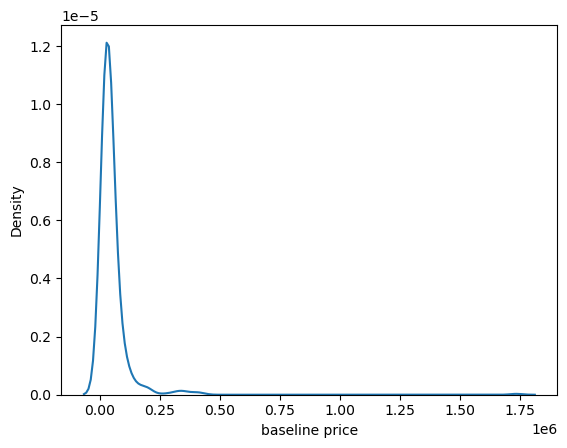

In [4]:
sns.kdeplot(data=df,x='baseline price')

88150.94999999998


<Axes: xlabel='baseline price', ylabel='Density'>

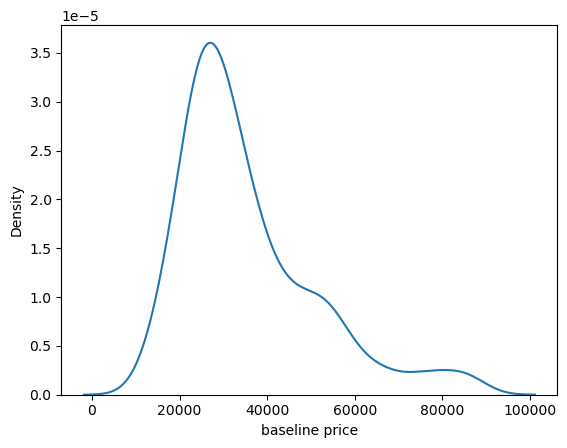

In [5]:
# Drop extremely expensive cars:
q90 = np.quantile( df['baseline price'],.9) # Compute the .9 quantile
print(q90)
keep = df['baseline price'] < q90  # Logical condition asserting price < .9 quantile
df = df.loc[keep,:] # Use locator function to filter on a Boolean conditional
df.describe()
sns.kdeplot(data=df,x='baseline price')

In [6]:
df['EPA class'].value_counts() # This is too fine-grained a set of distinctions for our purposes

SUV                       156
SUBCOMPACT CARS            63
MIDSIZE CARS               58
STANDARD PICKUP TRUCKS     53
COMPACT CARS               36
LARGE CARS                 26
TWO SEATERS                21
SMALL PICKUP TRUCKS        18
SMALL STATION WAGONS       15
VANS                       13
MINIVAN                     7
MIDSIZE STATION WAGONS      5
Name: EPA class, dtype: int64

In [7]:
# Simplify the vehicle classification scheme:
df['class'] = df['EPA class']
df['class'] = df['class'].replace(['MIDSIZE CARS','COMPACT CARS','SUBCOMPACT CARS','TWO SEATERS','LARGE CARS'],'car')
df['class'] = df['class'].replace(['SMALL STATION WAGONS','MIDSIZE STATION WAGONS'],'station wagon')
df['class'] = df['class'].replace(['STANDARD PICKUP TRUCKS','SMALL PICKUP TRUCKS'],'truck')
df['class'] = df['class'].replace(['VANS','MINIVAN'],'van')

In [8]:
df['class'].value_counts()

car              204
SUV              156
truck             71
station wagon     20
van               20
Name: class, dtype: int64

In [9]:
df.loc[:,['baseline price','EPA class']].groupby('EPA class').describe() # Baseline price by EPA vehicle class

baseline price                              \
                                count          mean           std   
EPA class                                                           
COMPACT CARS                     36.0  30685.694044  13789.906780   
LARGE CARS                       26.0  41878.111127  18197.377912   
MIDSIZE CARS                     58.0  38991.367105  18564.959399   
MIDSIZE STATION WAGONS            5.0  38471.230907  14671.061847   
MINIVAN                           7.0  28166.233885   4632.235846   
SMALL PICKUP TRUCKS              18.0  21852.599173   2967.604093   
SMALL STATION WAGONS             15.0  26478.173308   8598.652544   
STANDARD PICKUP TRUCKS           53.0  28644.924149   3712.092052   
SUBCOMPACT CARS                  63.0  39786.946362  20662.728969   
SUV                             156.0  36276.038126  13265.630531   
TWO SEATERS                      21.0  47560.811146  18510.449602   
VANS                             13.0  27569.407014   2030.828393   

                                                                  \
                                 min           25%           50%   
EPA class                                                          
COMPACT CARS            13645.560000  20301.440475  28159.408584   
LARGE CARS              21521.402318  27915.360000  34448.314153   
MIDSIZE CARS            15461.542184  23254.725000  34501.500000   
MIDSIZE STATION WAGONS  19971.607180  31869.347354  33874.200000   
MINIVAN                 21377.160000  25256.783783  27873.109632   
SMALL PICKUP TRUCKS     16203.698951  20504.332161  22100.735024   
SMALL STATION WAGONS    15549.900000  17334.900000  27888.840000   
STANDARD PICKUP TRUCKS  23513.158380  24678.477541  29100.067522   
SUBCOMPACT CARS         11783.040000  24136.022972  35951.413941   
SUV                     17913.329655  25774.364884  32711.075180   
TWO SEATERS             13499.700000  39550.500000  47064.840000   
VANS                    23799.020339  25925.340000  28319.669072   

                                                    
                                 75%           max  
EPA class                                           
COMPACT CARS            36522.733643  69742.500000  
LARGE CARS              51532.950000  81268.500000  
MIDSIZE CARS            50653.847155  87490.500000  
MIDSIZE STATION WAGONS  50770.500000  55870.500000  
MINIVAN                 31523.100000  34353.600000  
SMALL PICKUP TRUCKS     23627.025000  26641.565867  
SMALL STATION WAGONS    34599.328410  37612.500000  
STANDARD PICKUP TRUCKS  30652.866990  37840.535000  
SUBCOMPACT CARS         50936.250000  86353.200000  
SUV                     43136.206482  84377.468696  
TWO SEATERS             52611.600000  86439.900000  
VANS                    29432.100000  30411.300000

In [10]:
df.loc[:,['baseline price','class']].groupby('class').describe() # Baseline price by simplified vehicle class

baseline price                                            \
                       count          mean           std           min   
class                                                                    
SUV                    156.0  36276.038126  13265.630531  17913.329655   
car                    204.0  39021.420695  18857.153237  11783.040000   
station wagon           20.0  29476.437707  11321.733049  15549.900000   
truck                   71.0  26922.926268   4607.697988  16203.698951   
van                     20.0  27778.296419   3076.716822  21377.160000   

                                                                       
                        25%           50%           75%           max  
class                                                                  
SUV            25774.364884  32711.075180  43136.206482  84377.468696  
car            24223.980000  35267.658110  51016.575000  87490.500000  
station wagon  17602.650000  30156.575074  35414.575625  55870.500000  
truck          23909.662556  26394.033673  30116.107816  37840.535000  
van            25896.296891  28096.389352  29447.920444  34353.600000

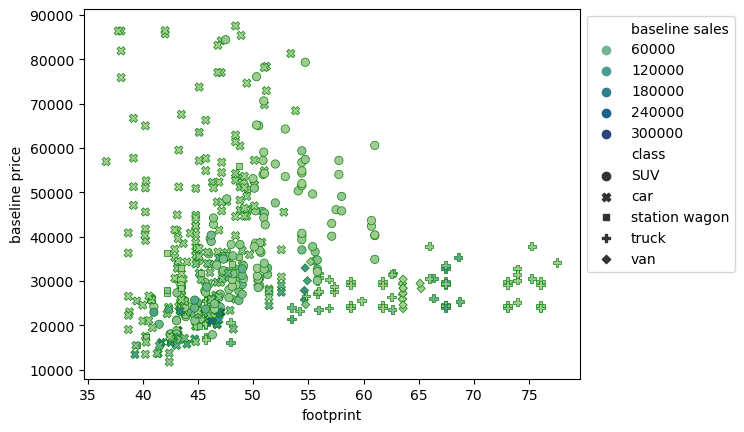

In [11]:
# Plot footprint against price
this_plot = sns.scatterplot(data=df,x='footprint',y='baseline price',
                            hue='baseline sales',style='class',
                           palette = 'crest',edgecolor='green')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

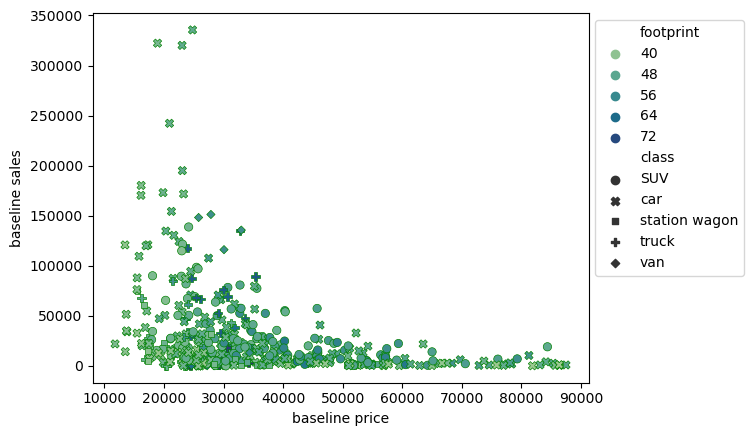

In [12]:
# Plot sales against price
this_plot = sns.scatterplot(data=df,x='baseline price',y='baseline sales',hue='footprint',style='class',
                           palette = 'crest',edgecolor='green')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

In [13]:
df.loc[:,['footprint','class']].groupby('class').describe() # Footprint by simplified vehicle class

footprint                                              \
                  count       mean        std        min        25%   
class                                                                 
SUV               156.0  49.198370   4.809056  41.008750  45.490313   
car               204.0  45.179790   3.740554  36.692097  42.900000   
station wagon      20.0  43.964019   2.900430  39.500000  42.197207   
truck              71.0  60.898435  10.104335  45.698300  54.485956   
van                20.0  60.163344   5.470372  45.300000  54.860885   

                                                
                     50%        75%        max  
class                                           
SUV            48.570469  51.300000  61.000000  
car            45.106705  47.633006  53.825797  
station wagon  43.310406  45.168965  49.420204  
truck          61.700000  67.400000  77.500000  
van            63.500000  63.562500  65.200000

# Machine Learning

## Machine Learning
- The following claim seems reasonable: "Suppose that a target variable $y$ follows from features $x$. If $x$ and $x'$ are close together, then $y$ and $y'$ are probably also close together." On some level, this is the core premise of machine learning.
- If that's true, then making a prediction $\hat{y}$ for a new case $\hat{x}$ could be done by finding the values of $x$ in the data close to $\hat{x}$, and averaging those values
- We'll operationalize this idea more precisely in the subsequent slides

## Prediction: Regression and Classification
- Let's focus on the graph below: a scatterplot of `baseline price` and `footprint`, with sales coded by hue and vehicle class coded by the marker
- Let's stipulate that we're interested in two questions:
    - Conditional on price and footprint, what are sales likely to be? (numeric outcome)
    - Conditional on price and footprint, what class of vehicle is it likely to be? (categorical outcome)
- Predicting a numeric outcome is called **regression**, and predicting a categorical outcome is called **classification**
- We often denote the **target variable** or **outcome variable** by $y$ and a prediction by $\hat{y}$, and we denote the **features** or **covariates** by $x$

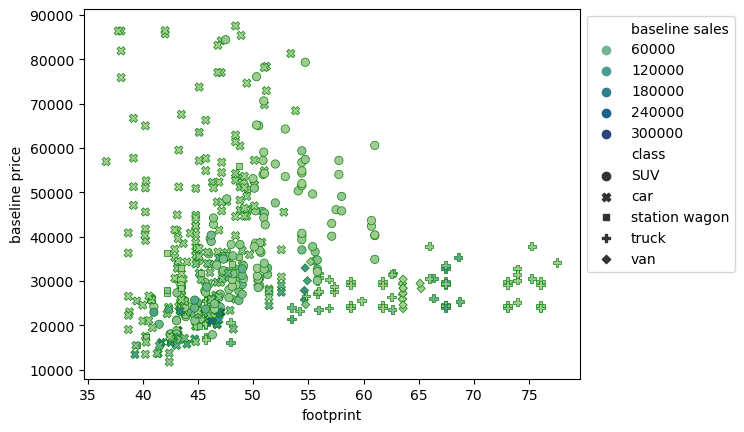

In [14]:
# Plot footprint against price
this_plot = sns.scatterplot(data=df,x='footprint',y='baseline price',
                            hue='baseline sales',style='class',
                           palette = 'crest',edgecolor='green')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## $k$ Nearest Neighbor Prediction Algorithm (Regression)
- Consider a new case $\hat{x} = (\hat{x}_1,...,\hat{x}_L)$. We want to make a guess of what value it will likely take, $\hat{y}$, given existing data $D = (X,y)$
- Suppose the outcome variable $y$ is numeric: Price, weight, time, decibels, etc.
- The *$k$ Nearest Neighbor Regression Algorithm* is:
  1. Compute the distance from $\hat{x}$ to each observation $x_i$
  2. Find the $k$ "nearest neighbors" $x_1^*$, $x_2^*$, ..., $x_K^*$ to $\hat{x}$ in the data, with outcomes $y_{1}^*$, $y_2^*$, ..., $y_K^*$
  3. Compute the average nearest neighhor outcome as the prediction for $\hat{x}$:
$$
  \hat{y} = \dfrac{y_1^* + y_2^* + ... + y_K^* }{K} =  \dfrac{1}{K} \sum_{k=1}^K y_k^*
$$


In [1]:
def knn_reg(x_hat,gdf,K):
    # Compute distances between x_hat and the data:  
    squared_differences = (x_hat - gdf.loc[:,['x1','x2']])**2
    distances = np.sum( squared_differences , axis = 1)
    # Find k smallest values in dist:
    neighbors = np.argsort(distances)[:K].tolist()
    # Find y values for the nearest neighbors:
    y_star = gdf['y'].iloc[neighbors].tolist()
    # Average neighbor values to get prediction:
    y_hat = np.mean(y_star)
    # Return a dictionary of computed values of interest:
    return {'y_hat':y_hat, 'y_star':y_star, 'neighbors':neighbors} 

In [16]:
# Cleaning the data a bit; we'll come back to this later
gdf = df.loc[:,['footprint', 'baseline price',  'baseline sales', 'class',]]
gdf = gdf.rename(columns={'footprint':'x1', 'baseline price':'x2', 'class':'g','baseline sales':'y'})

def maxmin(z):
    w = (z-np.min(z))/(np.max(z)-np.min(z))
    return w

gdf['x1'] = maxmin(gdf['x1'])
gdf['x2'] = maxmin(gdf['x2'])
gdf['y'] = maxmin(gdf['y'])

gdf.head()

,x1,x2,y,g
0,0.345715,0.448082,0.171003,SUV
1,0.206036,0.301227,0.063390,SUV
2,0.267299,0.477520,0.015292,car
3,0.272200,0.309544,0.169036,car
4,0.228091,0.233795,0.065550,car


{'y_hat': 0.18050046243452156, 'y_star': [0.21101319354002318, 0.3207666379569832, 0.009721555806558325], 'neighbors': [119, 130, 131]}


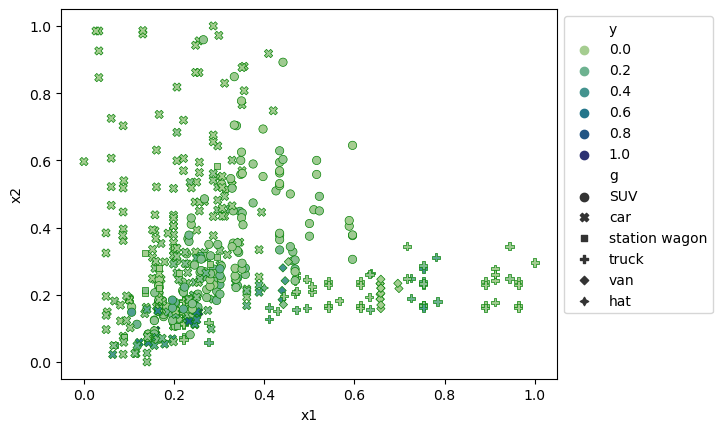

In [17]:
# Example:
x_hat = np.array((.4,.22)) # Example prediction case
knn = knn_reg(x_hat, gdf, 3) # Call our function
print(knn)

# Plot results:
gdf2 = gdf.copy() # Notice the .copy(); why?
hat_row = [ x_hat[0], x_hat[1],knn['y_hat'],'hat']
gdf2.loc[len(gdf2)] = hat_row
this_plot = sns.scatterplot(data=gdf2,x='x1',y='x2',hue='y',style='g',palette='crest',edgecolor='green') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## $k$ Nearest Neighbor Prediction Algorithm (Classification)
- Consider a new case $\hat{x} = (\hat{x}_1,...,\hat{x}_L)$. We want to make a guess of what **class** it will likely take, $\hat{g}$, given existing data $D = (X,g)$
- Suppose the outcome variable $y$ is categorical: Model, species, country, etc.
- The *$k$ Nearest Neighbor Classification Algorithm* is:
  1. Compute the distance from $\hat{x}$ to each observation $x_i$
  2. Find the $k$ "nearest neighbors" $x_1^*$, $x_2^*$, ..., $x_K^*$ to $\hat{x}$ in the data, with outcomes $g_{1}^*$, $g_2^*$, ..., $g_K^*$
  3. Compute either
        - The modal case among the neighbors, $g_{1}^*$, $g_2^*$, ..., $g_K^*$
        - A probability of each class occuring, proportional to the frequency in the neighbors $g_{1}^*$, $g_2^*$, ..., $g_K^*$

In [18]:
# A simple implementaton of kNN for classification:
def knn_class(x_hat,gdf,K):
    # Compute distances between x_hat and the data:  
    squared_differences = (x_hat - gdf.loc[:,['x1','x2']])**2
    distances = np.sum( squared_differences , axis = 1)
    # Find k smallest values in dist:
    neighbors = np.argsort(distances)[:K].tolist()
    # Find g values for the nearest neighbors:
    g_star = gdf['g'].iloc[neighbors]
    # Modal class:
    g_dist = g_star.value_counts()/K
    g_modal = g_dist.index[g_dist.argmax()]
    # Return a dictionary of computed values of interest:
    return {'neighbors':neighbors, 'g_star':g_star, 'g_dist':g_dist, 'g_modal':g_modal, }

{'neighbors': [446, 175, 82], 'g_star': 499    truck
188    truck
93     truck
Name: g, dtype: object, 'g_dist': truck    1.0
Name: g, dtype: float64, 'g_modal': 'truck'}
[0.8, 0.2, 100, 'truck']


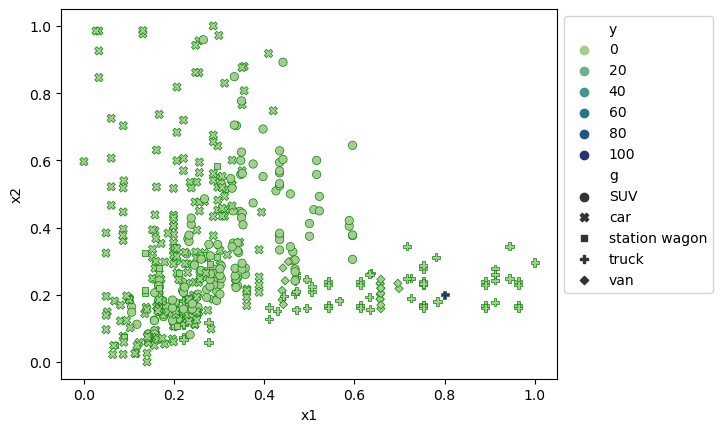

In [19]:
# Example:
x_hat = np.array((.8,.2)) # Example prediction case
knn = knn_class(x_hat, gdf, 3) # Call our function
print(knn)

gdf2 = gdf.copy()
hat_row = [ x_hat[0], x_hat[1],100, knn['g_modal']]
print(hat_row)
gdf2.loc[len(gdf2)] = hat_row
this_plot = sns.scatterplot(data=gdf2,x='x1',y='x2',hue='y',style='g', palette='crest',edgecolor='green') # Plot the fake data
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

# SciKit-Learn

## SciKit-Learn
- Unless we are doing something tailored to a particular task, we generally don't want to code our own algorithms: It is time consuming, and existing implementations are typically more efficient or robust than what we would create (but there is a lot of value in coding your own algorithms and estimators)
- The most popular Python machine learning library is called **SciKit-Learn**
- You typically import it as `from sklearn.<model class> import <model name>`, where `<model class>` is the set of related models and `<model name>` is the desired algorithm
    - In particular, `from sklearn.neighbors import KNeighborsRegressor` for regression and `from sklearn.neighbors import KNeighborsClassifier` for classification
- The workflow with `sk` is that you use it to
  1. Create an untrained model object with a fixed $k$: `model = KNeighborsRegressor(n_neighbors=k)` or `model = KNeighborsClassifier(n_neighbors=k)`
  2. Fit that object to the data, $(X,y)$: `fitted_model = model.fit(X,y)`
  3. Use the fitted object to make predictions for new cases $\hat{x}$: `y_hat = fitted_model.predict(x_hat)`

## Fitting a Model with kNN
- To prepare to fit the model we have to do a few things:
    - Import the model we want to use: `from sklearn.neighbors import KNeighborsRegressor`
    - Create a matrix `X` of features and a vector `y` for the target variable
    - **Scale the features in `X` so their values are comparable**
- Once we have our desired model imported and the data prepared as $D=(y,X)$, we can fit the model

## Feature/Variable Normalization/Scaling
- Problem: the distances in $k$NN depends on the "size/scale" of variables. Multiplying one variable by 10 or dividing by 100 (but not the others) will likely change your predictions
- Solution: We often **scale** or **normalize** variables to reduce the extent to which their relative values change the performance of the model
- There are a variety of approaches to this, but the simplest is **MaxMin Normalization**: For a vector $x$ and element $x_i$, 
$$
u_i = \dfrac{x_i - \min(x)}{\max(x)-\min(x)}
$$ 
- You do not have to normalize the outcome variable, $y$, since we don't look at any distances related to $y$ in fitting or using the model (in some algorithms, you would want to)
- SciKit calls this the `StandardScaler` (`from sklearn.preprocessing import StandardScaler`)

## The `.apply()` Method
- We'll make a maxmin scaler function:
```
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)
```
- But then we want to use it on each column of the data `X`
- Instead of a `for` loop, we can instead use the `df.apply(fcn)` method to apply the function `fcn` to each column

In [20]:
from sklearn.neighbors import KNeighborsRegressor # Import the kNN regression tool

# Select features/target variable for analysis:
y = df['baseline sales'] # Create target variable vector
X = df.loc[:,['baseline price','footprint']] # Create feature matrix
print(X.head())
print(X.describe())

   baseline price  footprint
0     45706.20000       50.8
1     34588.20000       45.1
2     47934.90000       47.6
3     35217.81622       47.8
4     29483.10000       46.0
       baseline price   footprint
count      471.000000  471.000000
mean     35405.635280   49.464881
std      15527.869064    8.020329
min      11783.040000   36.692097
25%      24498.166906   44.050000
50%      30565.639864   47.139583
75%      42406.500000   52.270833
max      87490.500000   77.500000


In [21]:
# Maxmin normalization function; Sci-kit calls it the "standard scaler"
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X to get U:
X = X.apply(maxmin)
print(X.head())
print(X.describe())

   baseline price  footprint
0        0.448082   0.345715
1        0.301227   0.206036
2        0.477520   0.267299
3        0.309544   0.272200
4        0.233795   0.228091
       baseline price   footprint
count      471.000000  471.000000
mean         0.312025    0.312998
std          0.205104    0.196539
min          0.000000    0.000000
25%          0.167951    0.180306
50%          0.248094    0.256016
75%          0.404497    0.381758
max          1.000000    1.000000


In [22]:
# Fit the model:
k=3
model = KNeighborsRegressor(n_neighbors=k) # Create a sk model for k=3
fitted_model = model.fit(X,y) # Train the model on our data

# Prediction

## Prediction
- Now that we have a fitted model, we can make predictions with it
- You can pass dataframes of $\hat{x}$ values into the `.predict(x_hat)` method of a fitted model
- This returns a set of predictions $\hat{y}$
- Let's plot the model predictions on a grid to see what it does
- The next code chunk is just a tool to make a picture, you don't need to follow each line

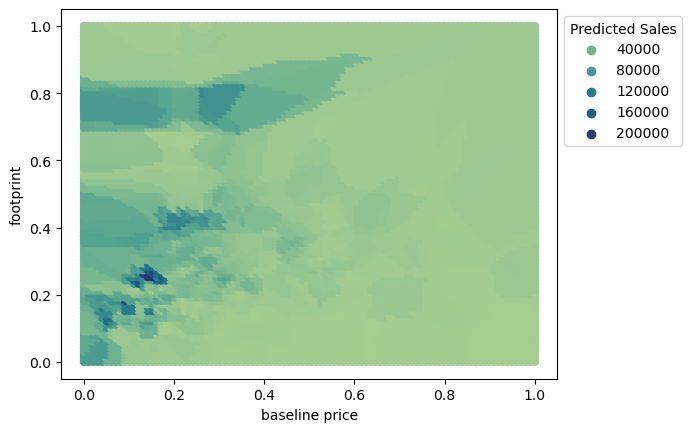

In [23]:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot

grid_x = np.linspace(0,1,N_x) # Create a grid of x values
grid_y = np.linspace(0,1,N_y) # Create a grid of y values

xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors

x_hat = pd.DataFrame({'baseline price':X,'footprint':Y}) # Create a dataframe of points to plot
y_hat = fitted_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted Sales'] = y_hat # Add new variable to the dataframe
# Create seaborn plot:
this_plot = sns.scatterplot(data=x_hat,x='baseline price',y='footprint',
                            hue='Predicted Sales', palette = 'crest', linewidth=0) 
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Changing the number of neighbors
- We'll look at how to pick $k$ in a few slides
- Before we do that, how does the predictive model change as $k$ changes?
- Basically, the decision boundaries will get "softer" and the predictions will become less binary
- At some point, the model turns to mush: Instead of using local information, you're using "most of the data", and the predictions will tend towards the sample average
- It is often useful to push models to extremes to see how they "break"
- **Underfitting** occurs when your model is too simple to reliably explain the phenomenon you are interested in, and **overfitting** occurs when your model is too complex to reliably explain the phenomenon you are interested in
- Notice the minimum and maximum predicted values in the legend, and the coarseness of the decision boundaries

In [24]:
def statics(k=3,data=df): # This function replicates our previous work, with k as an input
    y = df['baseline sales'] # Create target variable vector
    X = df.loc[:,['baseline price','footprint']] # Create feature matrix
    # Normalize:
    X = X.apply(maxmin)
    model = KNeighborsRegressor(n_neighbors=k) # Create a sk model for k=3
    fitted_model = model.fit(X,y) # Train the model on our data
    N_x = 100 # Coarseness of x variable
    N_y = 100 # Coarseness of y variable
    total = N_x*N_y # Total number of points to plot
    grid_x = np.linspace(0,1,N_x) # Create a grid of x values
    grid_y = np.linspace(0,1,N_y) # Create a grid of y values
    xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
    X = xs.reshape(total) # Turns pairs into vectors
    Y = ys.reshape(total) # Turns pairs into vectors
    x_hat = pd.DataFrame({'baseline price':X,'footprint':Y}) # Create a dataframe of points to plot
    y_hat = fitted_model.predict(x_hat) # Fit the model to the points
    x_hat['Predicted Sales'] = y_hat # Add new variable to the dataframe
    # Create seaborn plot:
    this_plot = sns.scatterplot(data=x_hat,x='baseline price',y='footprint',
                                hue='Predicted Sales',palette='crest',linewidth=0) 
    sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

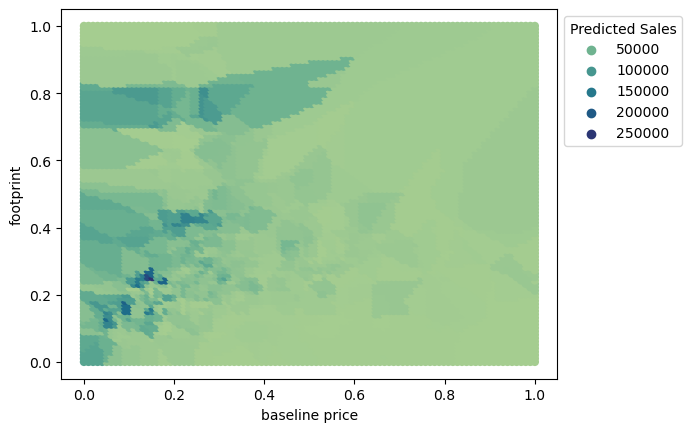

In [25]:
statics(2)

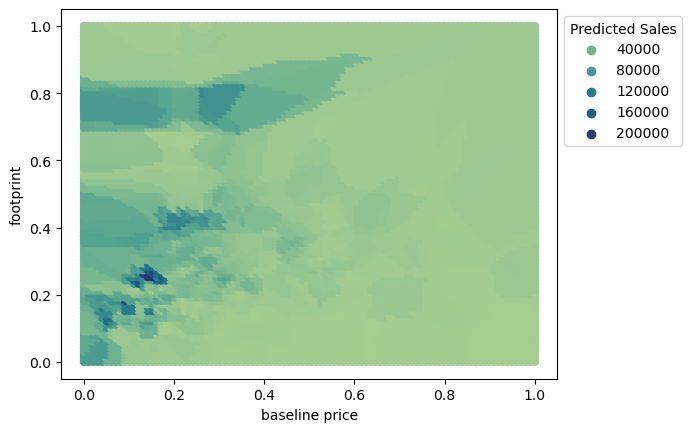

In [26]:
statics(3)

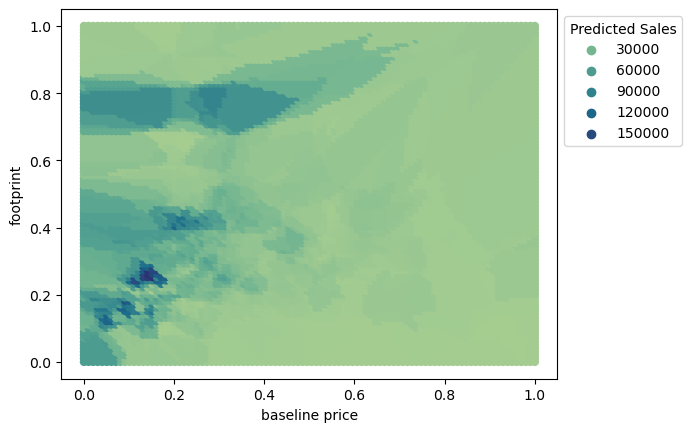

In [27]:
statics(4)

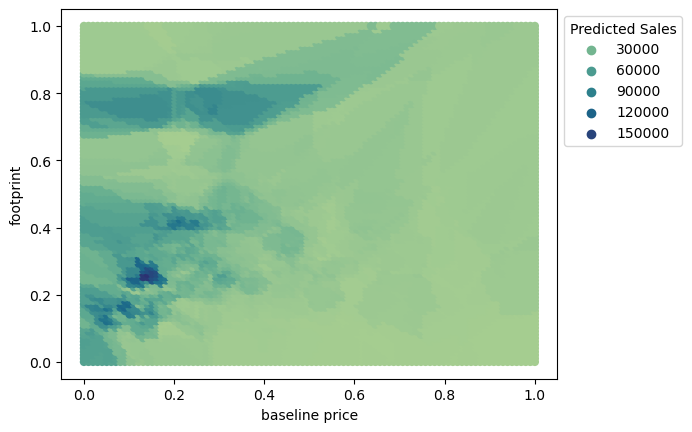

In [28]:
statics(5)

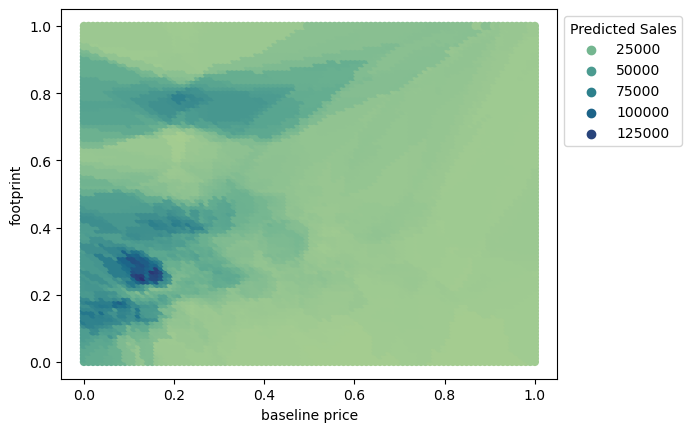

In [29]:
statics(10)

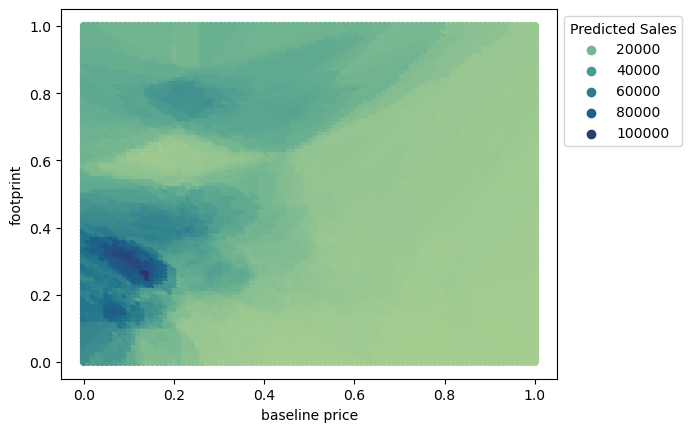

In [30]:
statics(20)

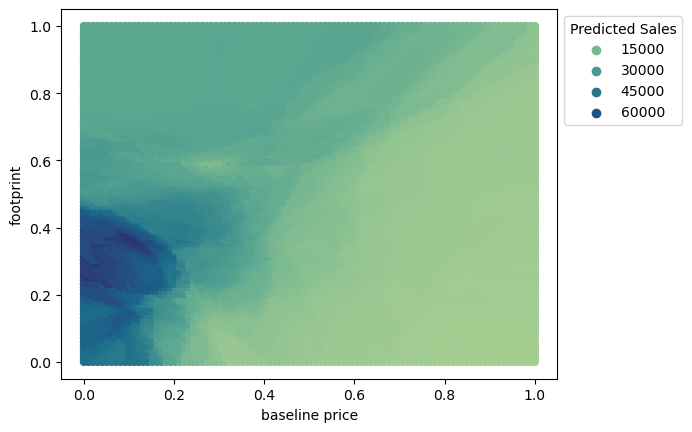

In [31]:
statics(50)

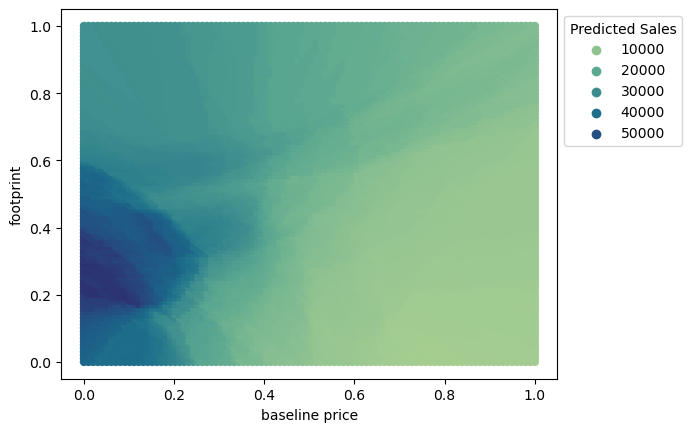

In [32]:
statics(100)

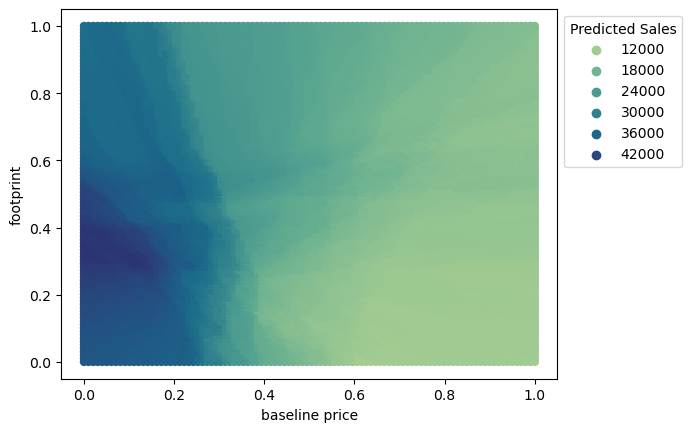

In [33]:
statics(200)

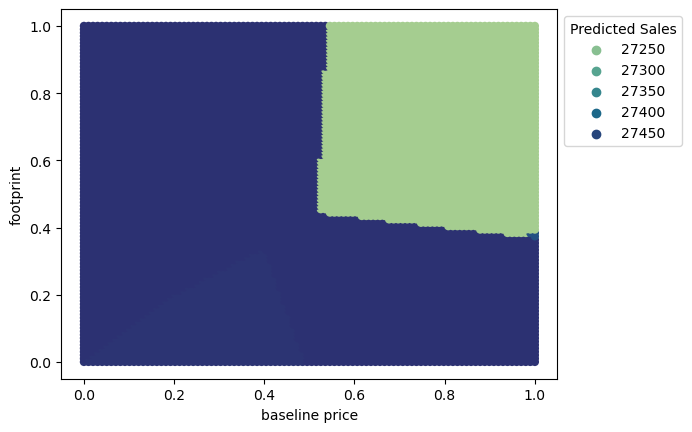

In [34]:
statics(470)

Why?

## Comparative Statics on $k$
- As $k$ goes up, the prediction regions get fuzzier
- The range of predicted values shrinks, because you're averaging over more values and extremes get moderated
- Eventually, you're averaging over so many neighbors that you make roughly the same predictions for everyone
- So the model can be unrealistically precise ($k$ is very small, overfitting) or unrealistically imprecise ($k$ is very large, underfitting)

## What happens if we fail to scale?
- Well, it doesn't "work", it looks really bad: This is an explanation of what not to do
- Since `baseline price` is in tens of thousands and `footprint` is in tens, we get "vertical" equivalence classes of predictions: The distance between one variable are uniformly larger than distances between the other, so there's immense pressure to pick neighbors with similar prices rather than footprints
- But we want to use both dimensions somewhat equally.
- When using algorithms based on distance metrics, you really have to make sure that the way you conceive of "distance" across dimensions makes sense.
- (An alternative is using smoothing to weight neighbors, like a kernel density plot, rather than a hard boundary that picks specific neighbors, like a histogram.)

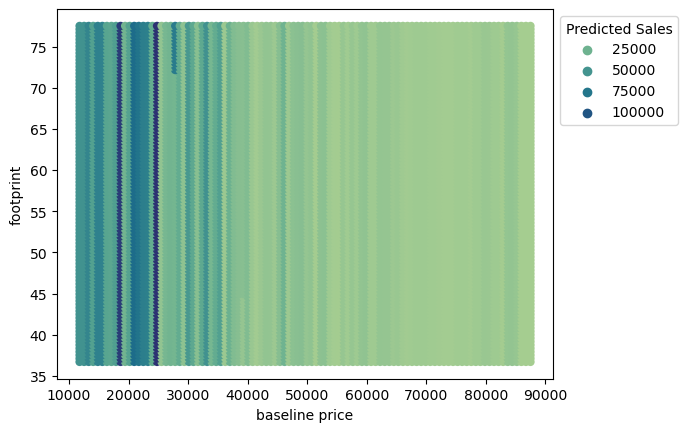

In [35]:
# Select features/target variable for analysis:
y = df['baseline sales'] # Create target variable vector
X = df.loc[:,['baseline price','footprint']] # Create feature matrix
model = KNeighborsRegressor(n_neighbors=3) # Create a sk model for k=3
fitted_model = model.fit(X,y) # Train the model on our data

# Make a plot of the decision rule:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot
xmin = np.min(X.iloc[:,0])
xmax = np.max(X.iloc[:,0])
ymin = np.min(X.iloc[:,1])
ymax = np.max(X.iloc[:,1])
grid_x = np.linspace(xmin,xmax,N_x) # Create a grid of x values
grid_y = np.linspace(ymin,ymax,N_y) # Create a grid of y values
xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors
x_hat = pd.DataFrame({'baseline price':X,'footprint':Y}) # Create a dataframe of points to plot
y_hat = fitted_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted Sales'] = y_hat # Add new variable to the dataframe
# Create seaborn plot:
this_plot = sns.scatterplot(data=x_hat,x='baseline price',y='footprint',
                            hue='Predicted Sales',palette='crest',linewidth=0) 
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

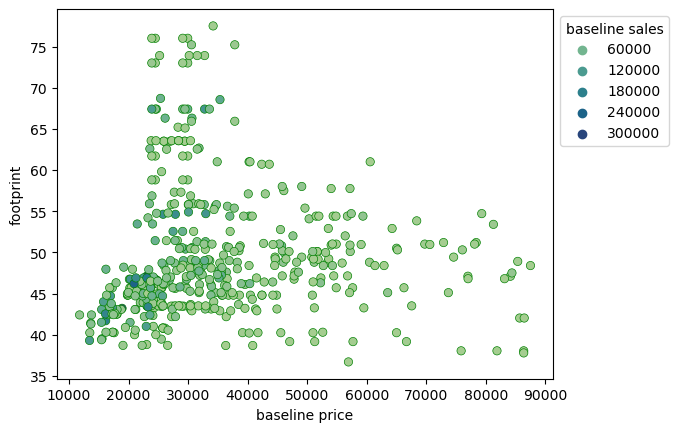

In [36]:
this_plot = sns.scatterplot(data=df,x='baseline price',y='footprint',hue='baseline sales',
                           palette = 'crest',edgecolor='green')
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

# Regression

## Fitting the Model
- In machine learning, one of the main concerns is **external validity** or **generalizability**: Will the model perform well in practice, on data that it wasn't trained to fit?
- A **heuristic/rule-of-thumb** is $k^* = \lfloor \sqrt{N} \rfloor$. For the car purchase data, $k^*=21$. But this isn't really data-driven at all.
- There are roughly two concerns: Models will overutilize features of the data that might be specific to this data and not be present in the population overall, and model **hyper parameters** like $k$ will tend to **overfit** and focus on feature of the data that are unlikely to appear in a new sample
- In general, models that fit well on training data are not guaranteed in any way to fit well on new data (when predictive performance matters)
- Depending on whether we're doing regression or classification, we have two fundamental quantities of interest:
    - For regression, residuals: The difference between predicted and actual values
    - For classification, the confusion table: A cross-tabulation of predicted and actual values
- These are the most fundamental metrics for whether a model has done well or poorly

## Regression and Residuals
- In regression, we start with the **errors** or **residuals** for each observation:

    \begin{alignat*}{1}
    e_i = y_i - \hat{y}_i(x_i,k)
    \end{alignat*}
- This quantifies how far off the $i$-th prediction is from the actual value
- We have a residual for each observation $i$, and we'll want to aggregate all those errors into metrics of model performance

## Fit and Sum of Squared Error
- What is a good fit?
- We usually have a distance metric in mind: "How far are the predictions from the true outcomes, on the validation/test set?"
- So for each observation $i$ in the validation set, we subtract the predicted value from the true one and square it, then sum over all the observations:
$$ 
SSE(k) = \sum_{i=1}^L (y_i - \hat{y}(x_i,k))^2 = \sum_{i=1}^L e_i^2
$$
- The $SSE(k)$ is a really common measure of how far the predicted values are from the true values
- Often, this is written more compactly in vector notation as $||y-\hat{y}||^2$: The squared norm of the distance between $y$ and $\hat{y}$

## Fitting the Model: Selecting $k$

- A simple and effective data-driven strategy is to randomly **split the data** into two sets, a **training set** and a **test/validation set**:
  - For a reasonable range of values $k = 1, 2, ..., \overline{K}$, we make a prediction $\hat{y}_i$ using the training set for each observation in the test set, $x_i$
  - Compute the squared difference from the prediction $\hat{y}_i$ to the true outcome $y_i$ for each point $i$ in the test set, then sum to get the *sum of squared error (SSE)*
  - Pick the $k$ that achieves the lowest SSE
- The variable $k$ a great example of a *hyperparameter*: The model and data themselves do not prescribe a value of $k$, and naive ways of picking it will lead to bad predictive models

## The Fundamental Thought Experiment of ML
- The following thought experiment is the core of machine learning and data science:
    - "I want to use my data to build a model that can predict what will happen tomorrow."
    - "To model that kind of uncertainty and validate whether the model is any good, I need data that my model has never seen."
    - "But I can create a sample of data my model has never seen: Split the sample into two or more chunks or folds, holding out some data from the training of the model to instead test its performance."
    - "As long as the data generating process in the future is like the data generating process in the past, performance on the hold-out data mimics future performance."
- Whenever we split the sample, we're substituting **uncertainty about future predictions** for **uncertainty about the hold-out data** in order to test the model
- This also is a useful way to conceptualize tools for model selection we'll learn later (cross validation, bootstrap validation, ensemble learning)

## Splitting the Sample
- `sk` has a `.model_selection` module that contains a `train_test_split` function that makes it easy to split your data
- Once the data are split, we use a `for` loop to compute the SSE for the training and test data for each reasonable value of $k$

In [37]:
y = df['baseline sales'] # Create target variable vector
X = df.loc[:,['baseline price','footprint']] # Create feature matrix
X = X.apply(maxmin) # Normalize X

# Split the sample:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

In [38]:
k_bar = 50 # Number of k's to try
SSE = [] # We'll store the SSE here 
SSE_on_train = [] # For pedogogical purposes, we'll save the training error

for k in range(k_bar):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test) # Predict values for test set
    SSE.append(np.sum( (y_test-y_hat)**2 )) # Save the computed SSE for test set
    y_hat = fitted_model.predict(X_train) # Predict values for training set
    SSE_on_train.append( np.sum( (y_train-y_hat)**2 ) ) # Save the computed SSE

SSE_min = np.min(SSE) # Find lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of SSE that equal the minimum
k_star = min_index[0]+1 # Find the optimal value of k; why index+1?
print(k_star)

[13]


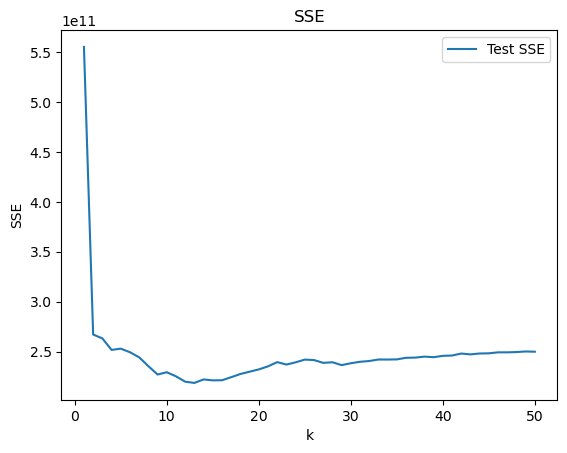

In [39]:
plt.plot(np.arange(1,k_bar+1),SSE,label='Test SSE') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")
plt.legend(loc='upper right')
plt.title('SSE')
plt.show()

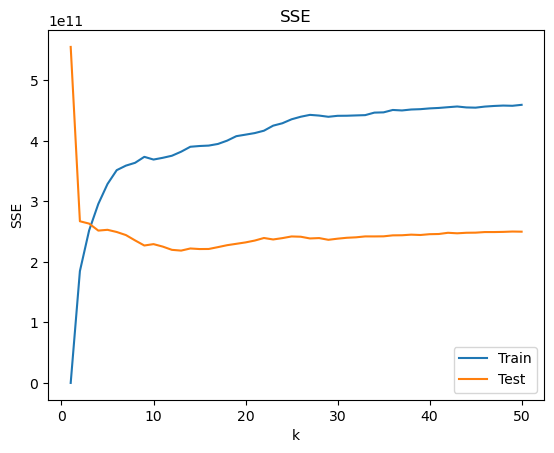

In [40]:
plt.plot(np.arange(1,k_bar+1),SSE_on_train,label='Train') # Plot SSE by k
plt.plot(np.arange(1,k_bar+1),SSE,label='Test') # Plot SSE by k
plt.xlabel("k")
plt.ylabel("SSE")
plt.legend(loc='lower right')
plt.title('SSE')
plt.show()

## Residual Plot
- With the optimal model, we can look at the residuals: Does the model do well, in general?
- For this one, there is a slight right tail: The model is struggling to differentiate a group of very popular cars, given the data it was trained on
- Knowing this is useful: We might look for variables that are correlated with model popularity besides price, or start including brand information
- Ideally, the residuals are centered at zero, bell-shaped, and symmetric, but the data don't always cooperate

[Text(0.5, 1.0, 'Residual Plot')]

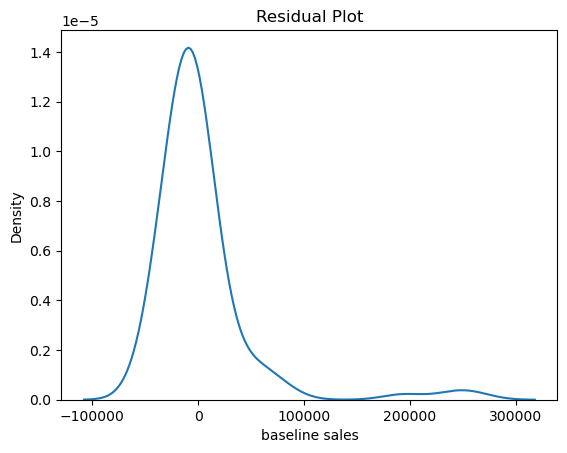

In [41]:
## Optimal model:
model = KNeighborsRegressor(n_neighbors=k_star[0]) # Create a sk model for k
fitted_model = model.fit(X_train,y_train) # Train the model on our data
y_hat = fitted_model.predict(X_test) # Predict values for test set
residual = y_test - y_hat

## Residual [lot:
sns.kdeplot(residual).set(title='Residual Plot')

## Training Error vs. Test Error
- Why does the training error increase in $k$?
- Or, what is the training SSE for $k=1$?

## The Best $k$ Depends on the Split
- There's a deep conflict at the core of the train/test split methodology: If you use the test data to pick hyperparameters, now you're just overfitting the model on the test data
- If I wanted to win Kaggle-style competitions, I would fit models on the TEST set, determine what works best, and then try to figure out how to get similar results on the TRAINING set: Essentially, reverse engineer winning models from knowledge of the test set (this is not good data science, and probably not ethical)
- This leads to alternatives we'll look at later in the class -- cross validation, ensemble learning -- that are meant to give more stable and robust results
- For now, train/test is enough to illustrate our concerns about hyperparameters, so we'll keep things simple
- To see why, let's run another simulation, where we implenent the 80/20 split different ways

[16]
[14]
[12]
[15]
[16]


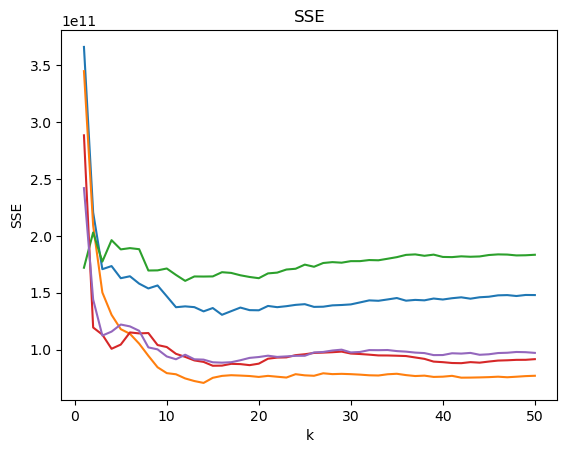

In [42]:
y = df['baseline sales'] # Create target variable vector
X = df.loc[:,['baseline price','footprint']] # Create feature matrix
X = X.apply(maxmin) # Normalize X

for k in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2) 

    SSE = [] # We'll store the SSE here 
    for k in range(k_bar):
        model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
        fitted_model = model.fit(X_train,y_train) # Train the model on our data
        y_hat = fitted_model.predict(X_test) # Predict values for test set
        SSE.append(np.sum( (y_test-y_hat)**2 )) # Save the computed SSE for test set

    SSE_min = np.min(SSE) # Find lowest recorded SSE
    min_index = np.where(SSE==SSE_min) # Find the indices of SSE that equal the minimum
    k_star = min_index[0]+1 # Find the optimal value of k; why index+1?
    print(k_star)
    plt.plot(np.arange(1,k_bar+1),SSE,label='Test') # Plot SSE by k

plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()

# Classification

## Regression versus Classification
- Our first application was a *regression* problem: Predicting a numeric or continuous value, which was sales
- Our next application is *classification*: Predicting which values are most likely when the outcome is categorical, which is vehicle category
- For example, instead of predicting sales, the goal might be to predict the class or make/model based on characteristics like price, engine size, fuel economy, number of doors, etc.

## Classification Example
- To illustrate how classification works, we are going to predict class from baseline price and footprint
- With classification, the goal is to either the probability that the new case will belong to each category or predict the most likely category

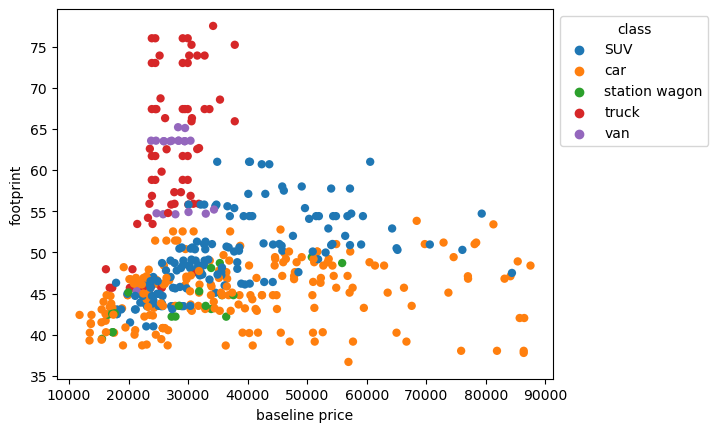

In [43]:
this_plot = sns.scatterplot(data=df,x='baseline price',y='footprint',hue='class',linewidth=0)
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Select features/target variable for analysis:
y = df['class']
X = df.loc[:,['baseline price','footprint']] # Create feature matrix

# Max-min normalize the features:
X = X.apply(maxmin)

# Fit the model:
model = KNeighborsClassifier(n_neighbors=3) # Create a sk model for k=3
classifier_model = model.fit(X,y) # Train the model on our data

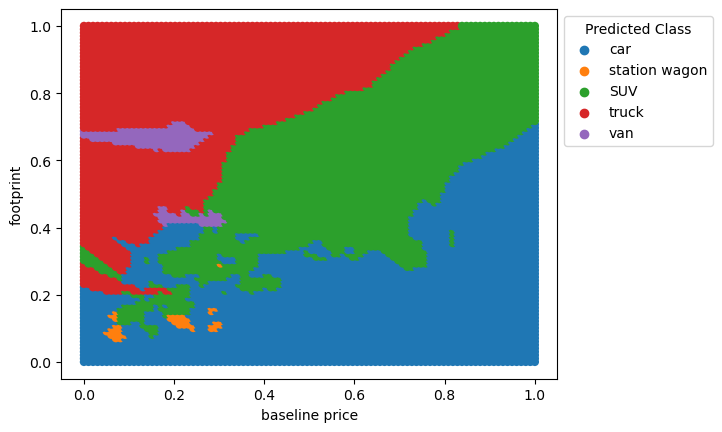

In [45]:
# Graph of predictor:
N_x = 100 # Coarseness of x variable
N_y = 100 # Coarseness of y variable
total = N_x*N_y # Total number of points to plot
grid_x = np.linspace(0,1,N_x) # Create a grid of x values
grid_y = np.linspace(0,1,N_y) # Create a grid of y values
xs, ys = np.meshgrid(grid_x,grid_y) # Explode grids to all possible pairs
X = xs.reshape(total) # Turns pairs into vectors
Y = ys.reshape(total) # Turns pairs into vectors
x_hat = pd.DataFrame({'baseline price':X,'footprint':Y}) # Create a dataframe of points to plot
y_hat = classifier_model.predict(x_hat) # Fit the model to the points
x_hat['Predicted Class'] = y_hat # Add new variable to the dataframe
# Create seaborn plot:
this_plot = sns.scatterplot(data=x_hat,x='baseline price',y='footprint',hue='Predicted Class', linewidth=0) 
sns.move_legend(this_plot, "upper left", bbox_to_anchor=(1, 1)) # Move legend off the plot canvas

## Confusion Matrices
- For classification, what's the most fundamental way of conceptualizing error? What's the classification version of a residual?
- To more broadly measure the performance of a classifier, we can cross-tabulate the predicted and true values in a **Confusion Matrix**, and look for patterns in the successes and failures


- For a binary classifier, like being positive or negative for a medical condition, a confusion table looks like this:

|             | Predicted Negative | Predicted Positive |
| :---------------- | ------: | ----: |
| Actually Negative | True Negative   | False Positive |
| Actually Positive | False Negative| True Positive |

- More generally, you just have the actual and predicted categories along the axes of the table:


|             | Predicted Category 1 | Predicted Category 2 | ... | Predicted Category L | 
| :---------------- | ------: | ----: | ----: | ----: |
| Actually Category 1 | True 1   | False 2 (1) | ... | False L (1) |
| Actually Category 2 | False 1 (2) | True 2 | ... | False L (2) |
| ... | ... | ... |... | ... |
| Actually Category L | False 1 (L)| False 2 (L)| ... | True L |


- You should always look at these for your classifier! They contain a lot of useful information about whether your model is doing well or poorly, and whether those errors are asymmetric or not!



## Accuracy
- With regression, the residuals are the most fundamental way of visualizing success or failure, and then we use SSE to aggregate the squared errors into a single metric of fit
- For classification, we can do a similar thing: What proportion of predictions were correct? This is called **accuracy**:
$$
\text{Accuracy} = \dfrac{ \text{\# Correct}}{N_{\text{test}}}
$$
- This is simple, but ignores the practical asymmetry between a false positive and a false negative (e.g. ebola, cancer)
- There are many other and more complex tools for evaluating whether a classifier performs well (e.g. Mathews Correlation Coefficient, precision/recall, ROC curves, F1 statistic)
- We'll target accuracy with our train-test split since it is simple and intuitive

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## Select data:
y = df['class'] # Target variable
X = df.loc[:,['baseline price','footprint']] # Create feature matrix
X = X.apply(maxmin) # Normalize X

In [47]:
## Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.5, # Split the sample 50 train/50 test
                                                    random_state=100) # For replication purposes
N_train = len(y_train)
N_test = len(y_test)

In [48]:
## Solve for k that maximizes accuracy:
k_bar = 100 # Number of k's to try
Acc = [] # We'll store the accuracy here 

for k in range(k_bar):
    model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train.values,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test.values) # Predict values for test set
    Acc.append( np.sum( y_hat == y_test )/N_test ) # Accuracy on testing data

Acc_max = np.max(Acc) # Find highest recorded Accuracy
max_index = np.where(Acc==Acc_max) # Find the indices that equal the maximum
k_star = max_index[0]+1 # Find the optimal value of k; why index+1?
print(k_star)

[ 9 13 23]


In [49]:
## Fit optimal model:
model = KNeighborsClassifier(n_neighbors=k_star[0]) # Create a sk model for k
fitted_model = model.fit(X_train.values,y_train) # Train the model on our data
y_hat = fitted_model.predict(X_test.values) # Predict values for test set

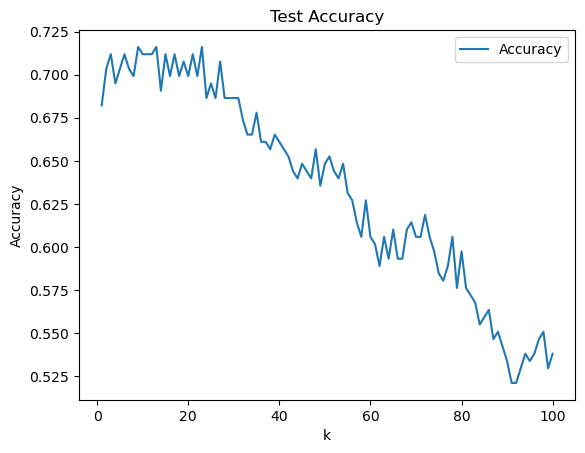

In [50]:
## Accuracy plot:
plt.plot(np.arange(1,k_bar+1),Acc,label='Accuracy') 
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.title('Test Accuracy')
plt.show()

In [51]:
## Confusion matrix:
pd.crosstab(y_test,y_hat)

col_0,SUV,car,truck,van
class,,,,
SUV,59,20,1,1
car,21,81,3,0
station wagon,1,9,0,0
truck,0,5,24,2
van,2,0,2,5


- Notice how, because of the random train/test split, no station wagons made it into the training data, so the algorithm only predicts SUV, car, truck, and van
- Despite that, it predicts that station wagons are most likely to be cars: It still does an OK job of guessing what the vehicle is closest to 

## Checking Our Work
- As for regression, the optimal number of neighbors can vary. The data are guiding the choice, and different splits of the data lead to different choices.
- If we run the same code five times without selecting the seed, what do we get?

[4]
[4]
[7]
[2]
[2 6]


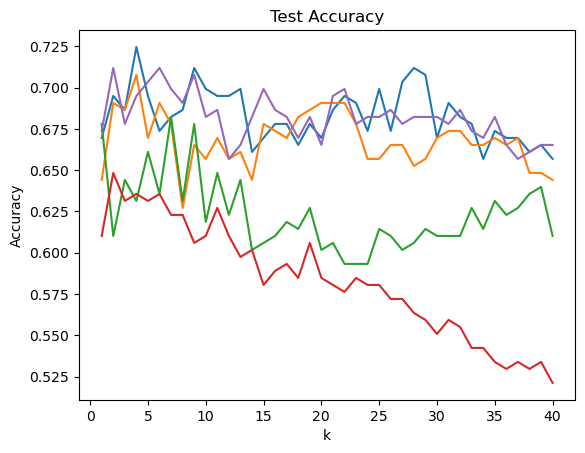

In [52]:
for k in range(5):
    ## Split the sample:
    X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                        test_size=.5) # Split the sample 50 train/50 test
    N_train = len(y_train)
    N_test = len(y_test)

    ## Solve for k that maximizes accuracy:
    k_bar = 40 # Number of k's to try
    Acc = [] # We'll store the accuracy here 

    for k in range(k_bar):
        model = KNeighborsClassifier(n_neighbors=k+1) # Create a sk model for k
        fitted_model = model.fit(X_train.values,y_train) # Train the model on our data
        y_hat = fitted_model.predict(X_test.values) # Predict values for test set
        Acc.append( np.sum( y_hat == y_test )/N_test ) # Accuracy on testing data

    Acc_max = np.max(Acc) # Find highest recorded Accuracy
    max_index = np.where(Acc==Acc_max) # Find the indices that equal the maximum
    k_star = max_index[0]+1 # Find the optimal value of k; why index+1?
    print(k_star)
    plt.plot(np.arange(1,k_bar+1),Acc,label='Accuracy') 

## Accuracy plot:
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title('Test Accuracy')
plt.show()

## Issues with $k$-NN
- This is a purely inductive/blackbox prediction algorithm: We find the $k$ cases that are "most similar" to $\hat{x}$ in terms of distance, and guess the average of the outcomes for those points
- The choice of $d$ is crucial but apparently arbitrary
- You can use as many variables as you want in principle, but in high dimensional spaces all points become close together and the concept of "neighbors" breaks down
    - In very high dimensions, the distance between points will tend to converge, so that everything is roughly a neighbor of everything else, and the model loses discriminatory power -- This is another hyperparameter to worry about, the variables included in the model
- For regression, it returns a *point prediction*, $\hat{y}$, and we might want to allow for more uncertainty in our predictions
- It is unclear how to interpret the impact of individual variables on predictions because of the local smoothing
- The local smoothing is "hard" like a histogram and not "smooth" like a kernel density; this leads to instability in predictions
- $k$-NN is our "chunkiest", "most local" predictive algorithm, so it is often good for imputation: It won't have significant global smoothing patterns that might interfere with another algorithm's learning on imputed data

## Main Take-aways
There is a lot in this lecture, if you are new to predictive modeling. We will revist most of it in future classes, but here are some key ideas:
- Euclidean Distance
- Regression versus Classification
- Feature Scaling/Normalization
- Splitting the Sample and Hyperparameter Fitting
- Sum of Squared Error
- kNN regression and classification
- The `.apply(fcn)` method